<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/Stock_Price_Oscillation_Modeling_and_Trading_Signal_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


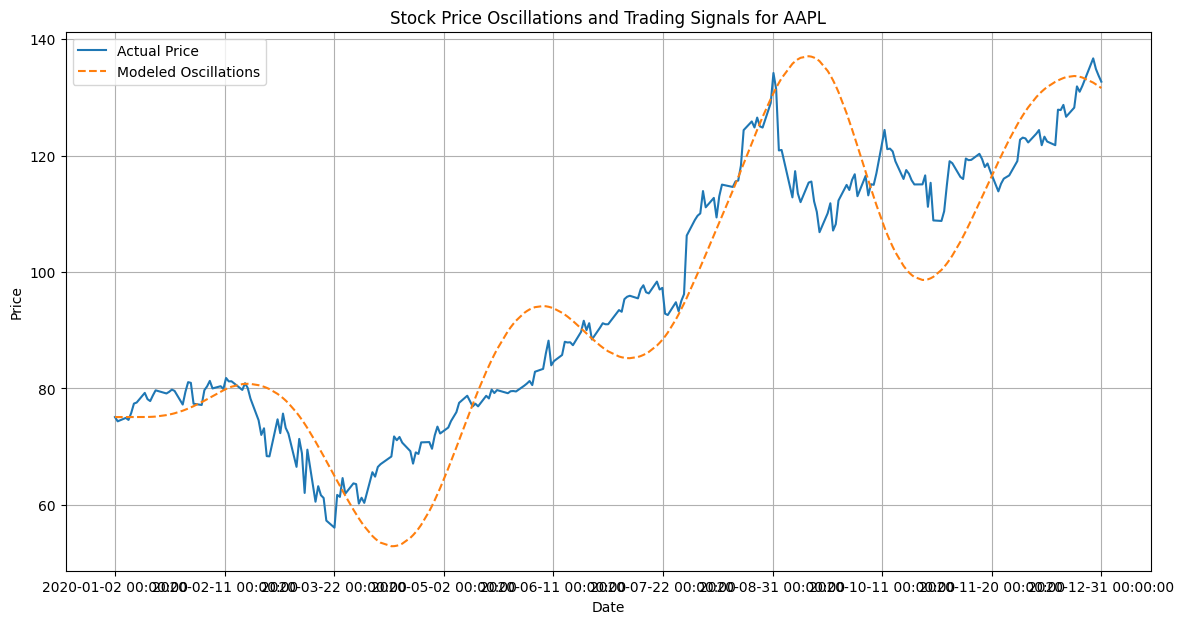

Trading signals for the next 5 days:
Day 1: Sell
Day 2: Sell
Day 3: Sell
Day 4: Sell
Day 5: Sell


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import datetime

# Fetch data from Yahoo Finance
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']

# Identify support and resistance using EMA smoothing
def find_levels(prices, window=20):
    ema = prices.ewm(span=window, adjust=False).mean()
    support = prices.rolling(window, center=True).min().fillna(ema)
    resistance = prices.rolling(window, center=True).max().fillna(ema)
    return support, resistance

# Model the stock price as a damped oscillator
def oscillator_model(t, y, alpha, beta, support, resistance):
    p, v = y
    midpoint = (support(t) + resistance(t)) / 2
    dpdt = v
    dvdt = -alpha * (p - midpoint) - beta * v
    return [dpdt, dvdt]

# Generate buy, sell, or hold signals based on the model's predictions
def generate_signals(prices, predicted_prices):
    signals = []
    for i in range(len(prices) - 1):
        if predicted_prices[i + 1] > predicted_prices[i]:
            signals.append('Buy')
        elif predicted_prices[i + 1] < predicted_prices[i]:
            signals.append('Sell')
        else:
            signals.append('Hold')
    return signals

# Main function to execute the model
def main():
    ticker = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2021-01-01'
    prices = fetch_data(ticker, start_date, end_date)
    prices.index = (prices.index - pd.to_datetime('1970-01-01')).days

    support, resistance = find_levels(prices)

    # Interpolating support and resistance for continuous functions
    support_interp = interp1d(prices.index, support, fill_value="extrapolate")
    resistance_interp = interp1d(prices.index, resistance, fill_value="extrapolate")

    # Constants for the model
    alpha = 0.005  # Reduced oscillation strength
    beta = 0.01    # Increased damping coefficient
    initial_price = prices.iloc[0]
    initial_velocity = 0

    # Time span for the simulation
    t_span = [prices.index.min(), prices.index.max()]
    t = np.array(prices.index)

    # Solve the differential equation
    sol = solve_ivp(oscillator_model, t_span, [initial_price, initial_velocity],
                    args=(alpha, beta, support_interp, resistance_interp), t_eval=t)

    # Generate trading signals for the next 5 days
    predicted_prices = sol.y[0]
    signals = generate_signals(prices, predicted_prices)[-5:]

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(prices.index, prices.values, label='Actual Price')
    plt.plot(prices.index, predicted_prices, label='Modeled Oscillations', linestyle='--')
    plt.title(f'Stock Price Oscillations and Trading Signals for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(ticks=np.linspace(prices.index.min(), prices.index.max(), num=10),
               labels=[pd.to_datetime('1970-01-01') + datetime.timedelta(days=int(x)) for x in np.linspace(prices.index.min(), prices.index.max(), num=10)])
    plt.show()

    # Print the trading signals
    print("Trading signals for the next 5 days:")
    for i, signal in enumerate(signals):
        print(f"Day {i+1}: {signal}")

if __name__ == "__main__":
    main()
